## Product view embeddings exploration

Given product view session data this notebook can be used to process the data into sessions then perform an embedding using word2vec

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random
#import urllib2 #uncomment for Python 2
import urllib #uncomment for Python 3
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import json
from IPython.core.display import Image, display

Preprocessing step, load data and then process into the format that is required for the gensim implementation of word2vec. A session is defined as a set of product views where any one view is no longer than 1 hour from the previous. 

In [2]:
"""viewsSchema = ['customerId',
               'dateViewed','productId',
               'target_sales_value',
               'target_returned_value',
               'target_net_value',
               'target_churned']

#load view data
views = pd.read_table('/Users/duncan.little/CustomerProfiling/item_embedding/local_resources/views1in10000.csv', 
                         sep = ',')

#parse dates 
views.dateViewed = pd.to_datetime(views.dateViewed, unit  = 's')"""

viewsSchema = ['customerId',
                'productId',
                'variantId',
                'divisionId',
                'sourceId',
                'itemQty',
                'dateViewed',
                'origin',
                'price',
                'discountType',
                'useForRecs',
                'dateModified',
                'viewonly',
                'changeThumbnail',
                'imageZoom',
                'watchVideo',
                'view360',
                'sizeGuide',
                'device',
                'userTime',
                'misc1',
                'misc2',
                'misc3']

#load desktop view data
desktopViews = pd.read_table('desktop_product_views_01_03_17.tab', 
                         sep = '|', 
                      names = viewsSchema,
                     usecols = ['customerId','productId','dateViewed'])


#load app view data
"""
appViews = pd.read_table('app_product_views_01_03_17.tab', 
                         sep = '|', 
                      names = viewsSchema,
                     usecols = ['customerId','productId','dateViewed'])
"""

#views = pd.concat([desktopViews, appViews])

views = desktopViews

views.dateViewed = pd.to_datetime(views.dateViewed)

#sort data by customerId then dateViewed. This ensures that session views are in chronological order
views = views.sort_values(['customerId','dateViewed'])

print('Sorted data')

#find time since last view between product views. If it is the first ever product view of a customer
#then fill with unreasonably high time difference 
time_diffs = views.groupby('customerId')

print('Finished groupby')

time_diffs = time_diffs.apply(lambda x: (x['dateViewed'] - x['dateViewed'].shift(1)))

print('Found time diffs')

time_diffs  = time_diffs.reset_index().set_index('level_1')
time_diffs = time_diffs.rename(columns = {'dateViewed' : 'time_since_last_view'})

views = views.merge(time_diffs['time_since_last_view'].to_frame(),how='inner',left_index = True,right_index = True)
views = views.reset_index(drop = True)
views.time_since_last_view = views.time_since_last_view.fillna(dt.timedelta(hours = 100000))

#add a session marker start of session marker, this is added if the time since the previous
#product view is greater than 1 hour.
views['session_marker'] = views.apply(
    (lambda x: 1 if x['time_since_last_view'] > dt.timedelta(hours = 1) else 0),axis = 1)

#Get a list of strings split by the session marker (1 marks the start of a new session)
views['productId_string'] = views.productId.astype(str)
products_and_sessions = views[['productId_string','session_marker']].values
split_sess = np.split(products_and_sessions, np.where(products_and_sessions[:, 1] == 1)[0][1:])

sentences = []

#Write out list into one session per line sentences
with open('session_sentences.txt','w') as file:

    for line in split_sess:
        
        sentence = line[:,:1].flatten().tolist()
        
        if(len(sentence) == 1): continue
        
        file.write(" ".join(sentence))
        file.write('\n')
        
        sentences.append(sentence)

/Users/duncan.little/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Sorted data
Finished groupby
Found time diffs


Run gensim

In [4]:
model = gensim.models.Word2Vec(sentences, min_count=10)  # default value is 5

2017-03-16 09:27:24,319 : INFO : collecting all words and their counts
2017-03-16 09:27:24,320 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-03-16 09:27:24,356 : INFO : PROGRESS: at sentence #10000, processed 74119 words, keeping 33468 word types
2017-03-16 09:27:24,432 : INFO : PROGRESS: at sentence #20000, processed 151369 words, keeping 49736 word types
2017-03-16 09:27:24,482 : INFO : PROGRESS: at sentence #30000, processed 234392 words, keeping 61519 word types
2017-03-16 09:27:24,535 : INFO : PROGRESS: at sentence #40000, processed 318960 words, keeping 70328 word types
2017-03-16 09:27:24,581 : INFO : PROGRESS: at sentence #50000, processed 411185 words, keeping 77641 word types
2017-03-16 09:27:24,645 : INFO : PROGRESS: at sentence #60000, processed 504838 words, keeping 83578 word types
2017-03-16 09:27:24,703 : INFO : PROGRESS: at sentence #70000, processed 598520 words, keeping 88267 word types
2017-03-16 09:27:24,755 : INFO : PROGRESS: at s

Pick a random product and display images of original and most similar 

6969304
Similarity: Original


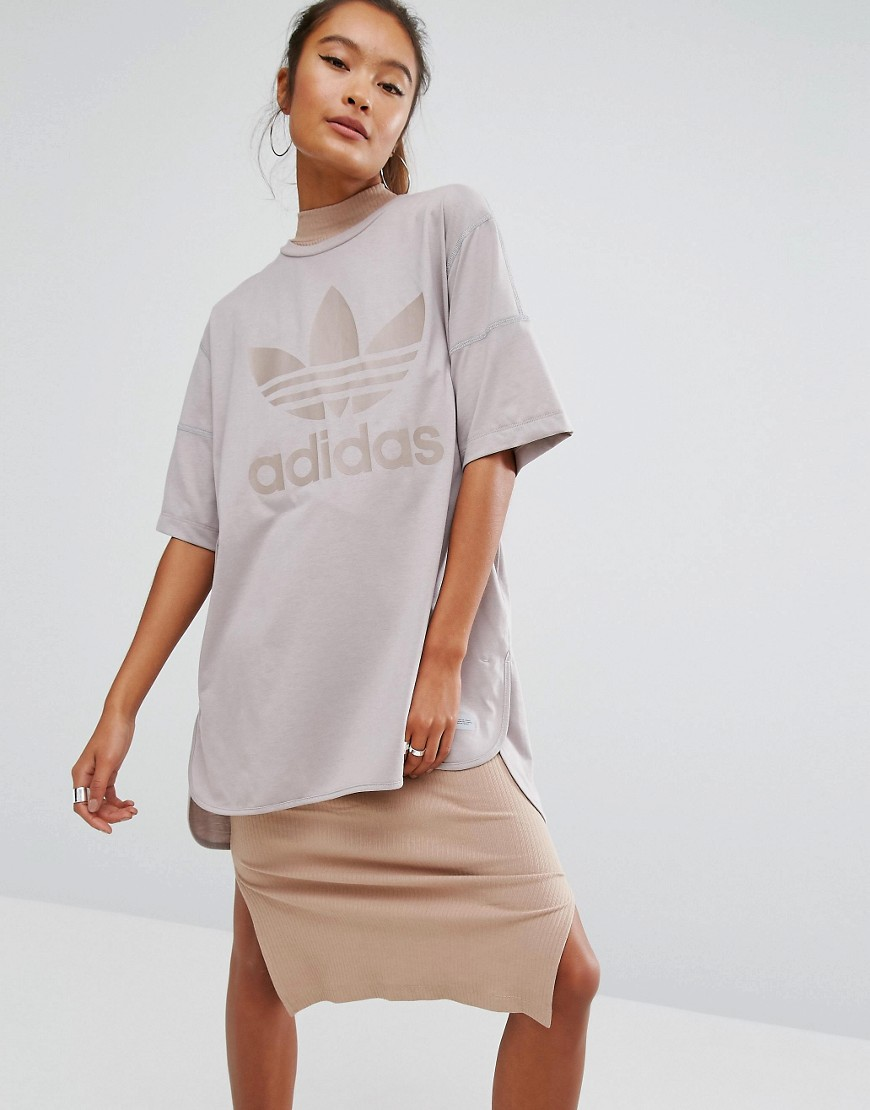

7334566
Similarity: 0.996508002281189


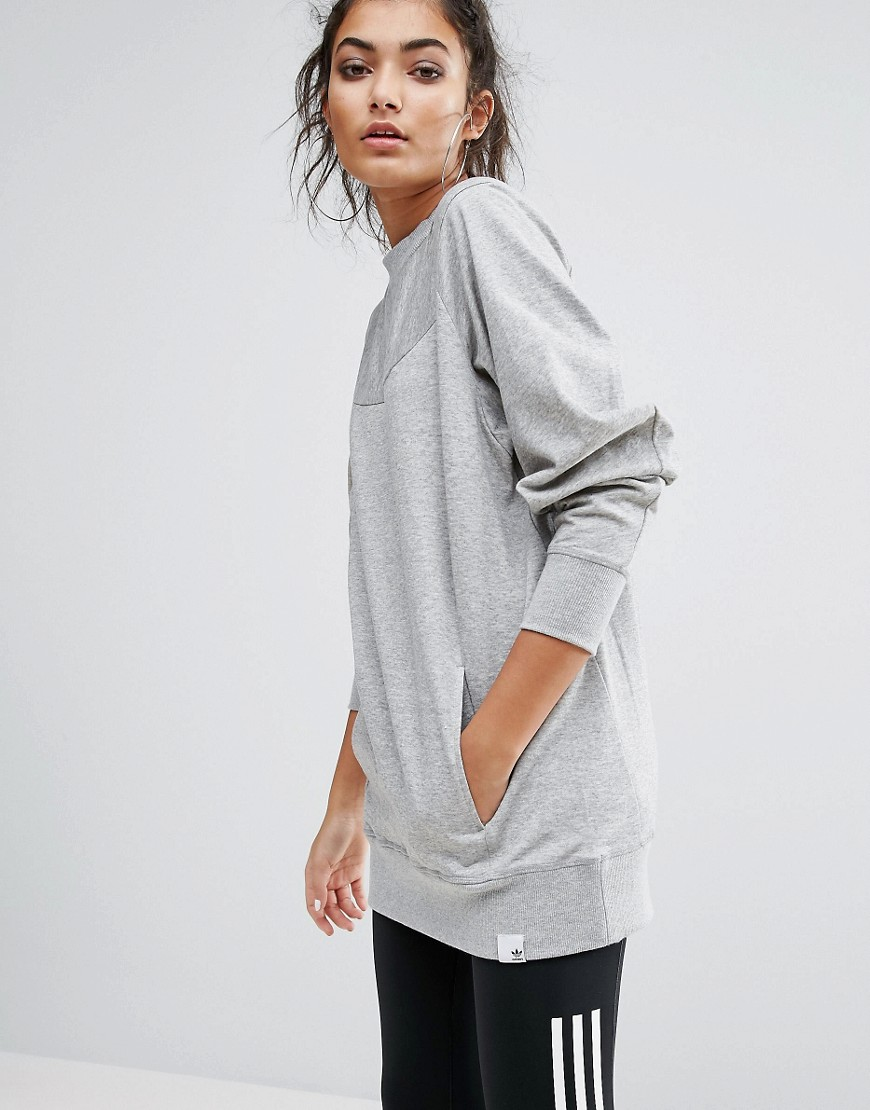

7335316
Similarity: 0.9961520433425903


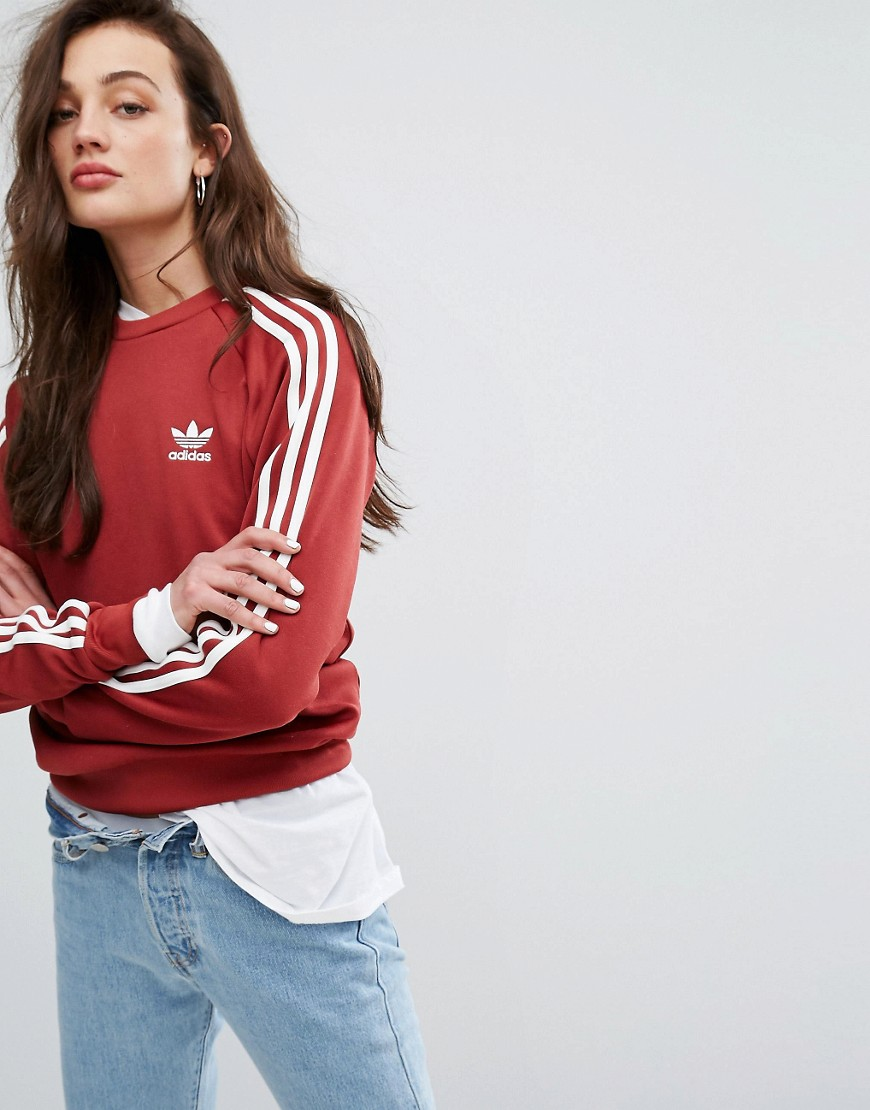

7334545
Similarity: 0.9951276779174805


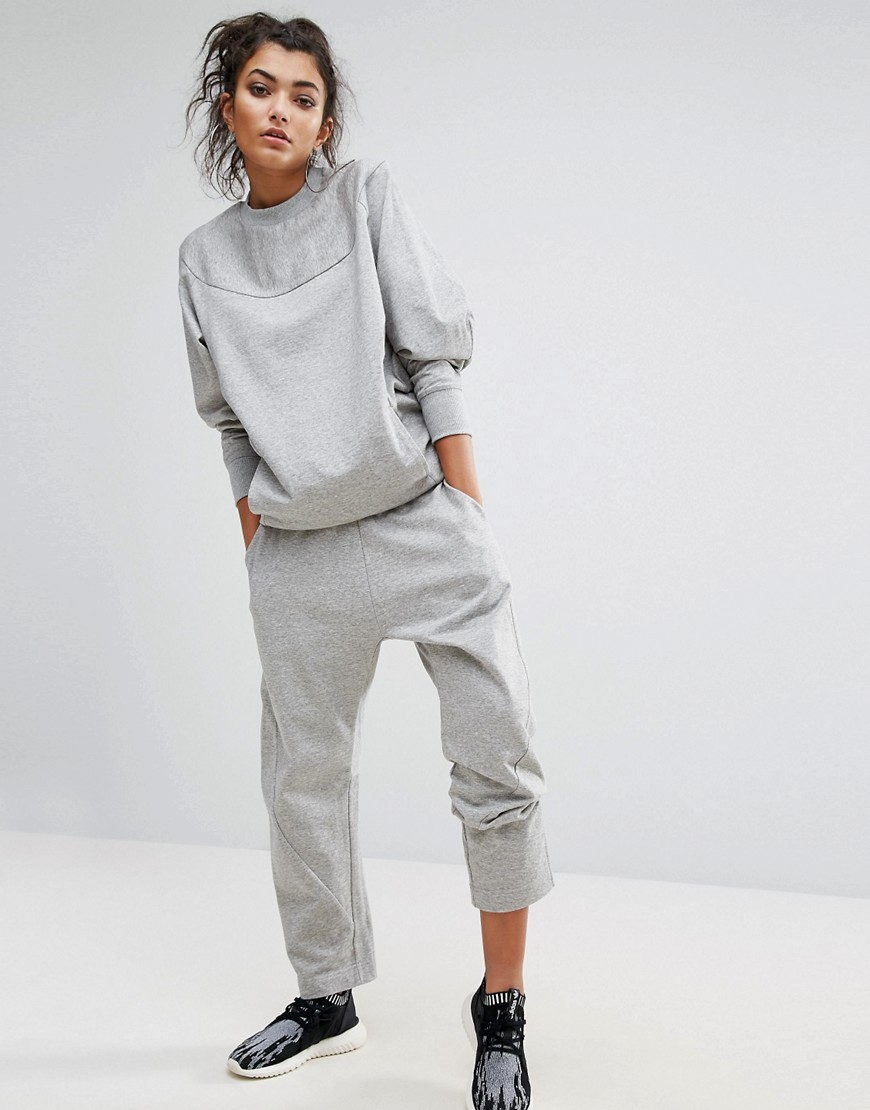

7334252
Similarity: 0.9944939017295837


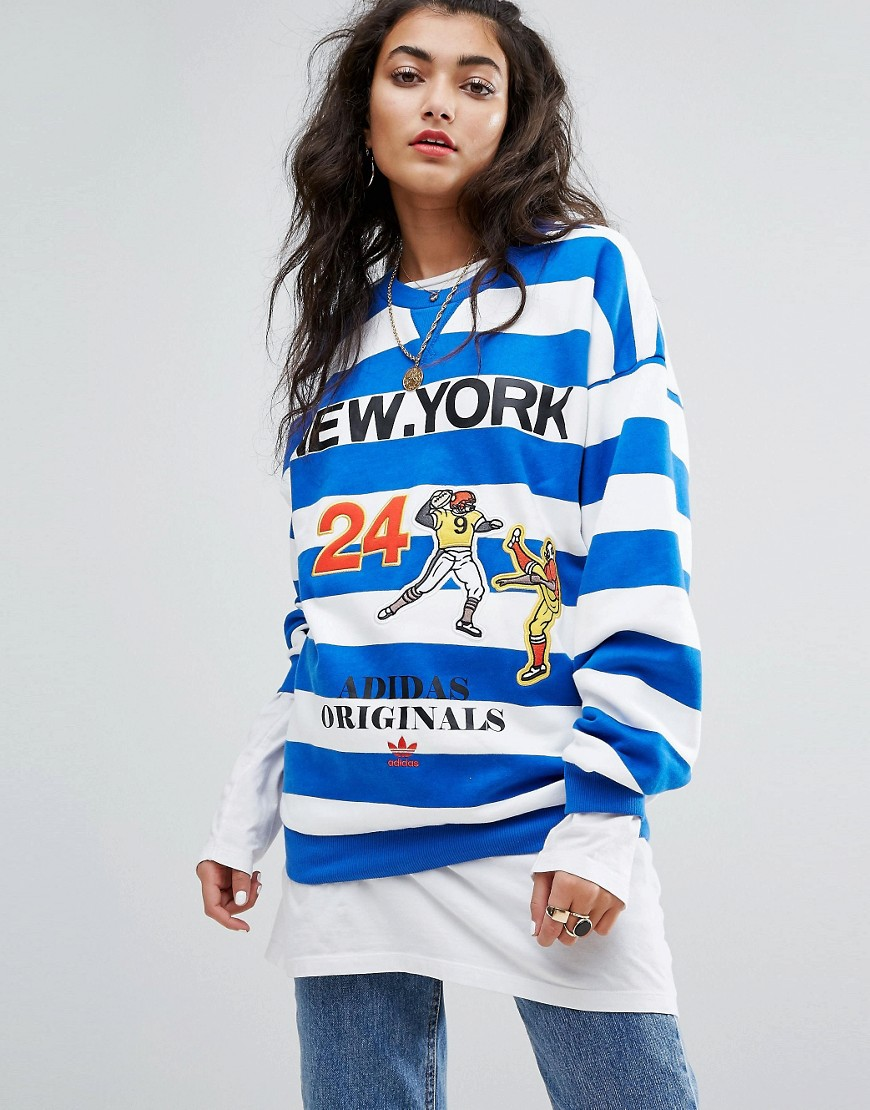

7334254
Similarity: 0.9914724826812744


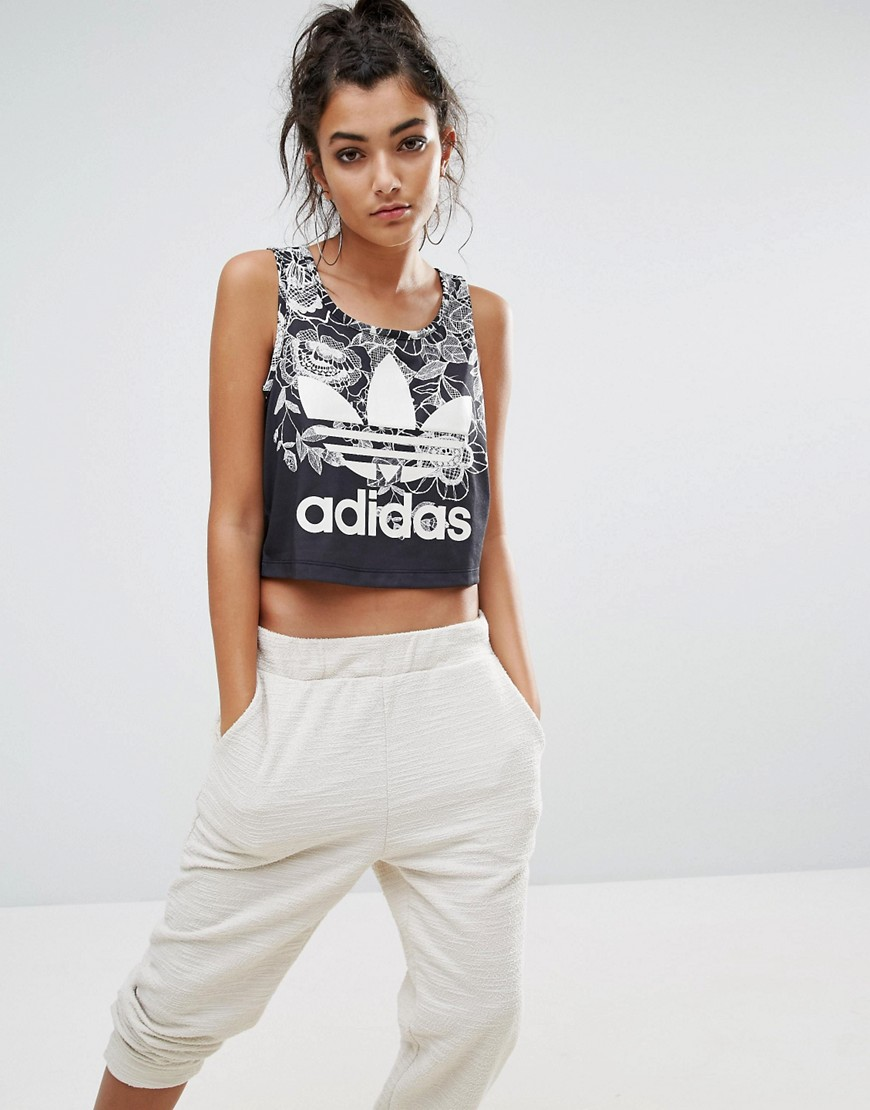

7015242
Similarity: 0.9911817312240601


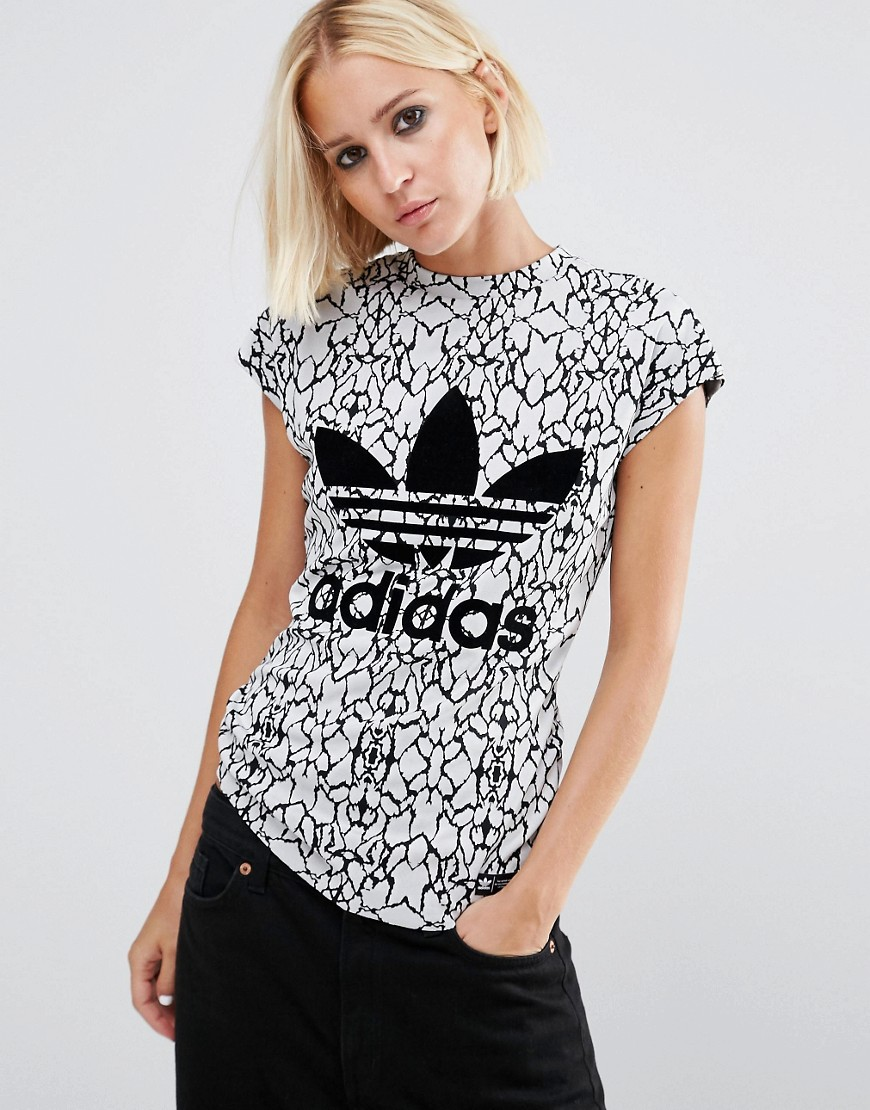

7104820
Similarity: 0.9910773038864136


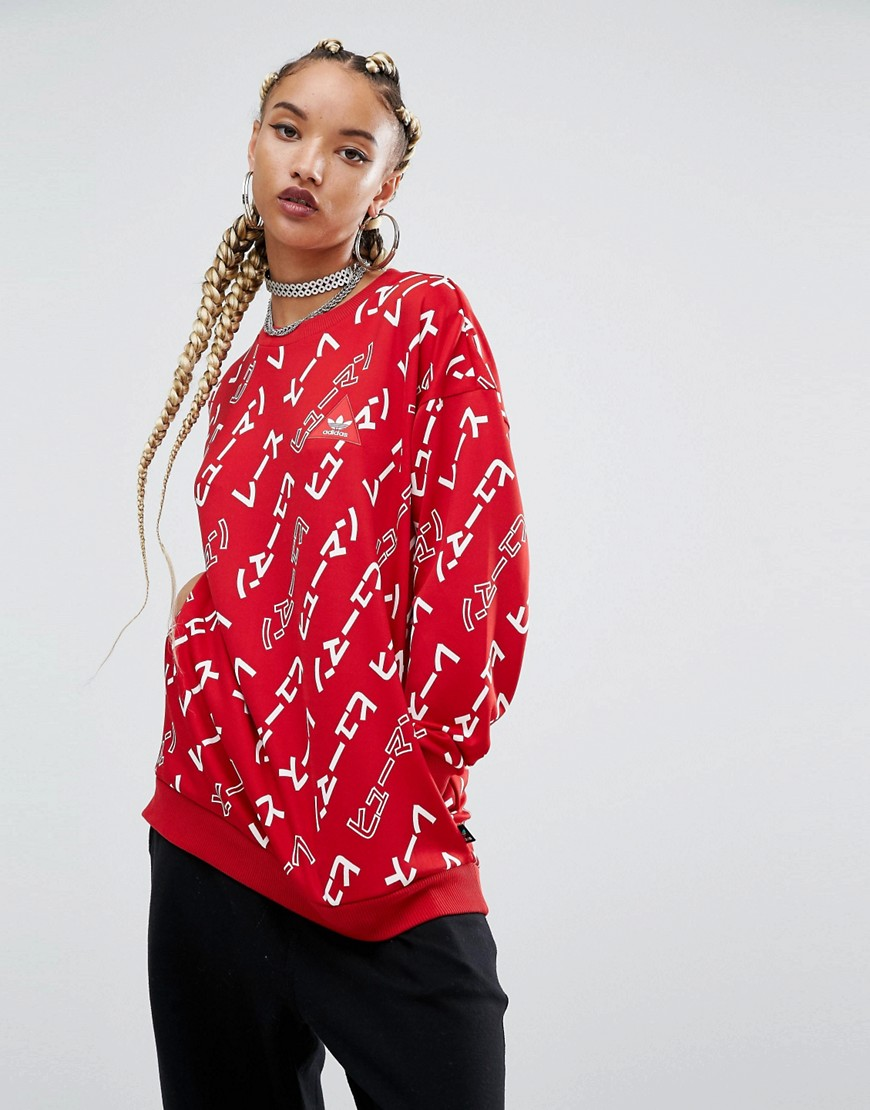

7136477
Similarity: 0.9909996390342712


7334555
Similarity: 0.9896946549415588


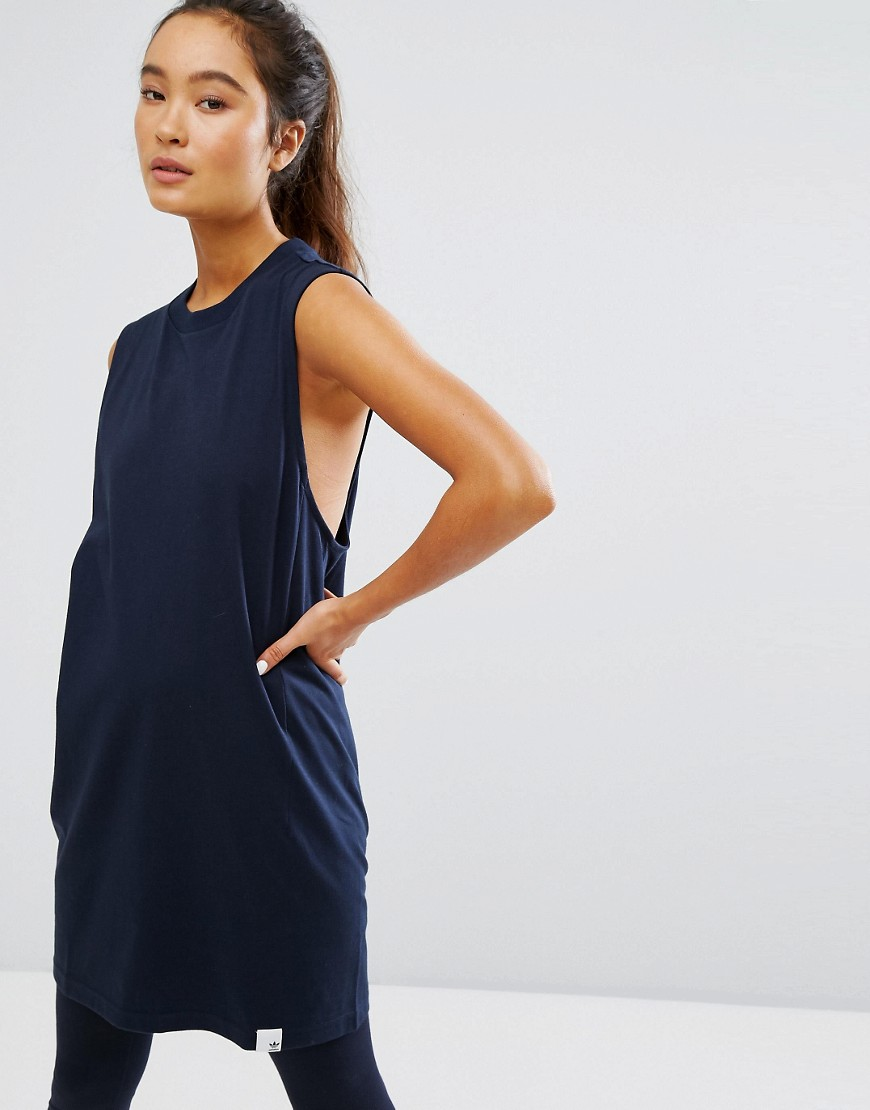

7136619
Similarity: 0.9893406629562378


In [7]:
product = random.choice(random.choice(sentences))

most_similar = model.most_similar([product], [], 10)

original = (product,'Original')

most_similar.insert(0, original)

for productId, similarity in most_similar: 
    
    #uncomment for Python2
    #data = json.load(urllib2.urlopen('http://es-sor-recs-cs.cloudapp.net:29200/products2/v1/'+str(productId)))

    #uncomment for Python3
    data = json.load(urllib.request.urlopen('http://es-sor-recs-cs.cloudapp.net:29200/products2/v1/'+str(productId)))
    
    image_url = data['_source']['imageloc']
    
    print(productId)
    print('Similarity:', similarity )
    display(Image(image_url, width=500, unconfined=True))